In [1]:
import sys
import warnings
import numpy as np
from astropy import constants as c
from astropy import units as u
from numba import jit

from astroquery.jplhorizons import Horizons

sys.path.append("/epyc/projects/thor/thor")

from thor.orbits.propagate import calcChi, calcC2C3, propagateUniversal
from thor import Constants as c

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MU = c.G * c.M_SUN

In [3]:
minor_planet = Horizons(id="156734", epochs=58762, location="@sun")
vectors = minor_planet.vectors()
vectors = np.array(vectors["x", "y", "z", "vx", "vy", "vz"]).view("float64")
r_mp = vectors[:3]
v_mp = vectors[3:]
dt=100

observer = Horizons(id="Eros", epochs=58762, location="@sun")
vectors = observer.vectors()
vectors = np.array(vectors["x", "y", "z", "vx", "vy", "vz"]).view("float64")
r_obs = vectors[:3]
v_obs = vectors[3:]
#r_obs = np.array([1., 0., 0.]) 
#v_obs = np.array([0., -np.sqrt(MU), 0.]) 

In [4]:
%%timeit
propagateUniversal(r_mp, v_mp, dt, mu=MU, maxIterations=100, tol=1e-16)

6.69 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
r_mps = []
v_mps = []
r_obss = []
v_obss = []

for i in np.arange(1, 3000, 1):
    r2, v2 = propagateUniversal(r_mp, v_mp, i, mu=MU, maxIterations=100, tol=1e-16)
    r_mps.append(r2)
    v_mps.append(v2)
    
    r2, v2 = propagateUniversal(r_obs, v_obs, i, mu=MU, maxIterations=100, tol=1e-16)
    r_obss.append(r2)
    v_obss.append(v2)
    
r_mps = np.array(r_mps)
v_mps = np.array(v_mps)
r_obss = np.array(r_obss)
v_obss = np.array(v_obss)

Text(0.5, 0, 'X [au]')

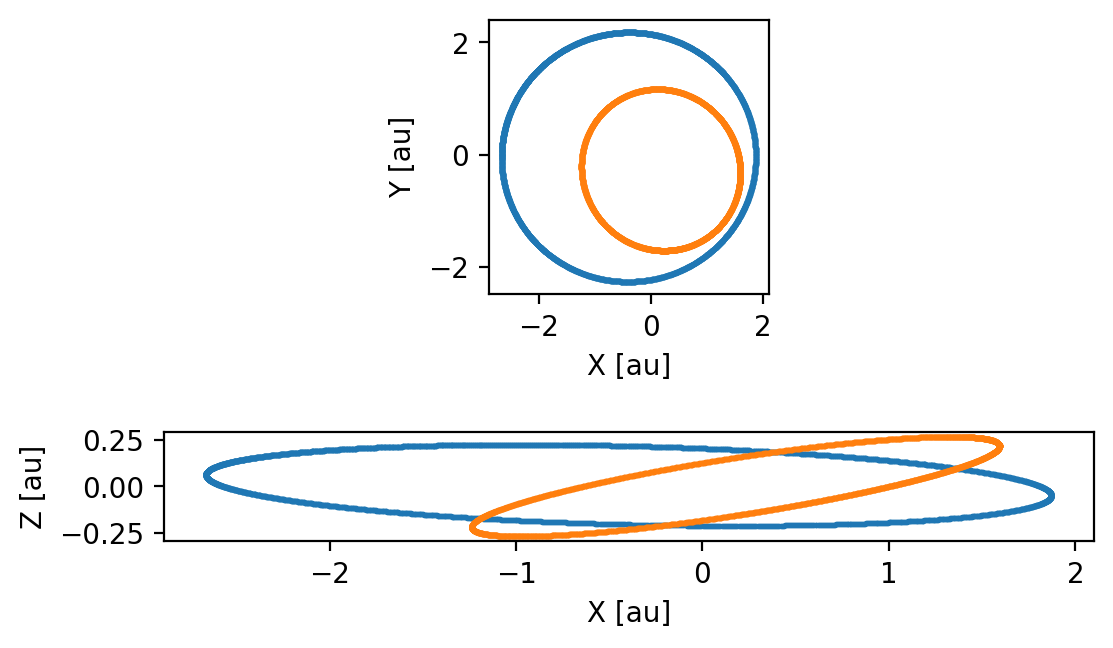

In [6]:
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].scatter(*r_mps[:, :2].T, s=1)
ax[0].scatter(*r_obss[:, :2].T, s=1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("X [au]")
ax[0].set_ylabel("Y [au]")

ax[1].scatter(*r_mps[:, [0, 2]].T, s=1)
ax[1].scatter(*r_obss[:, [0, 2]].T, s=1)
ax[1].set_aspect("equal")
ax[1].set_ylabel("Z [au]")
ax[1].set_xlabel("X [au]")

Text(0.5, 0, 'X [au]')

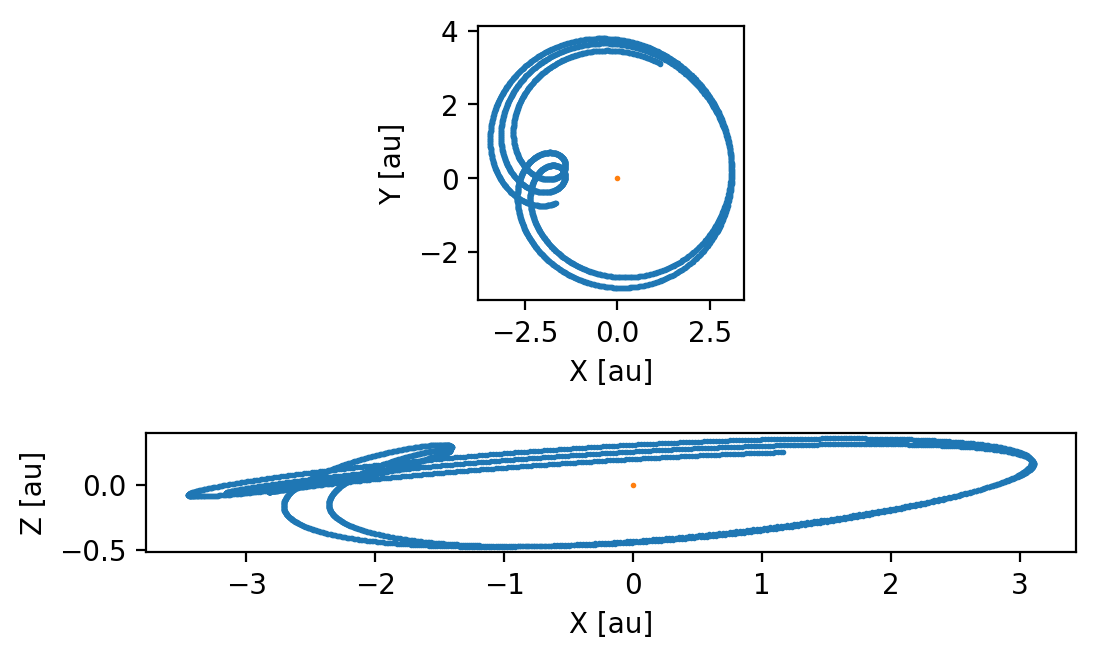

In [7]:
delta = r_mps - r_obss
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].scatter(*delta[:, :2].T, s=1)
ax[0].scatter(0,0, s=1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("X [au]")
ax[0].set_ylabel("Y [au]")

ax[1].scatter(*delta[:, [0, 2]].T, s=1)
ax[1].scatter(0,0, s=1)
ax[1].set_aspect("equal")
ax[1].set_ylabel("Z [au]")
ax[1].set_xlabel("X [au]")

In [10]:
rho = 
np.linalg.norm(delta)

162.7613511143772

In [ ]:
from thor.orbits.iod import gaussIOD
from thor.coordinates import _cartesianToAngular
from thor.coordinates import eclipticCartesianToAngular
from thor.coordinates import eclipticToEquatorialAngular

In [ ]:
selected_obs = [500, 505, 510]
truth_r = r_mps[selected_obs]
truth_v = v_mps[selected_obs]
coords_obs = r_obss[selected_obs]
coords_ec_cart = delta[selected_obs]
t = np.array(selected_obs)

coords_ec_ang = eclipticCartesianToAngular(_cartesianToAngular(coords_ec_cart[0,:], coords_ec_cart[1,:], coords_ec_cart[2,:]))
coords_eq_ang = eclipticToEquatorialAngular(coords_ec_ang)

In [ ]:
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].scatter(*truth[:, :2].T, s=1)
ax[0].scatter(*coords_obs[:, :2].T, s=1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("X [au]")
ax[0].set_ylabel("Y [au]")

ax[1].scatter(*truth[:, [0, 2]].T, s=1)
ax[1].scatter(*coords_obs[:, [0, 2]].T, s=1)
ax[1].set_aspect("equal")
ax[1].set_ylabel("Z [au]")
ax[1].set_xlabel("X [au]")

In [ ]:
fig, ax = plt.subplots(2, 1)
ax[0].scatter(*np.degrees(coords_eq_ang[:, :2].T))
ax[1].scatter(*np.degrees(coords_ec_ang[:, :2].T))

In [ ]:
orbits = gaussIOD(coords_eq_ang, t, coords_obs)

In [ ]:
orbits

In [ ]:
truth

In [ ]:
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].scatter(*truth[:, :2].T, s=1)
ax[0].scatter(*orbits[:, :2].T, s=1)
ax[0].scatter(*coords_obs[:, :2].T, s=1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("X [au]")
ax[0].set_ylabel("Y [au]")

ax[1].scatter(*truth[:, [0, 2]].T, s=1)
ax[1].scatter(*orbits[:, [0, 2]].T, s=1)
ax[1].scatter(*coords_obs[:, [0, 2]].T, s=1)
ax[1].set_aspect("equal")
ax[1].set_ylabel("Z [au]")
ax[1].set_xlabel("X [au]")

In [ ]:
from thor.coordinates import equatorialToEclipticCartesian
from thor.coordinates import equatorialAngularToCartesian

from scipy import roots
from thor.orbits.iod import calcHerrickGibbs, calcGibbs, calcGauss
from thor import Constants as c

MU = c.G * c.M_SUN
C = c.C

def _calcV(rho1hat, rho2hat, rho3hat):
    # Vector triple product that gives the area of 
    # the "volume of the parallelepiped" or according to 
    # to Milani et al. 2008: 3x volume of the pyramid with vertices q, r1, r2, r3.
    # Note that vector triple product rules apply here.
    return np.dot(np.cross(rho1hat, rho2hat), rho3hat)

def _calcA(q1, q2, q3, rho1hat, rho3hat, t31, t32, t21):
    # Equation 21 from Milani et al. 2008
    return np.dot(np.cross(np.linalg.norm(q2)**3 * rho1hat, rho3hat), (t32 * q1 - t31 * q2 + t21 * q3))

def _calcB(q1, q3, rho1hat, rho3hat, t31, t32, t21):
    # Equation 19 from Milani et al. 2008
    return np.dot(np.cross(MU / 6 * t32 * t21 * rho1hat, rho3hat), ((t31 + t32) * q1 + (t31 + t21) * q3))

def _calcLambdas(r2_mag, t31, t32, t21):
    # Equations 16 and 17 from Milani et al. 2008
    lambda1 = t32 / t31 * (1 + MU / (6 * r2_mag**3) * (t31**2 - t32**2))
    lambda3 = t21 / t31 * (1 + MU / (6 * r2_mag**3) * (t31**2 - t21**2))
    return lambda1, lambda3

def _calcRhos(lambda1, lambda3, q1, q2, q3, rho1hat, rho2hat, rho3hat, V):
    # This can be derived by taking a series of scalar products of the coplanarity condition equation
    # with cross products of unit vectors in the direction of the observer, in particular, see Chapter 9 in
    # Milani's book on the theory of orbit determination 
    numerator = -lambda1 * q1 + q2 - lambda3 * q3
    rho1_mag = np.dot(numerator, np.cross(rho2hat, rho3hat)) / (lambda1 * V)
    rho2_mag = np.dot(numerator, np.cross(rho1hat, rho3hat)) / V
    rho3_mag = np.dot(numerator, np.cross(rho1hat, rho2hat)) / (lambda3 * V)
    return np.dot(rho1_mag, rho1hat), np.dot(rho2_mag, rho2hat), np.dot(rho3_mag, rho3hat)

def _calcFG(r2_mag, t32, t21):
    # Calculate the Lagrange coefficients (Gauss f and g series)
    f1 = 1 - (1 / 2) * MU / r2_mag**3 * (-t21)**2
    f3 = 1 - (1 / 2) * MU / r2_mag**3 * t32**2
    g1 = -t21 - (1 / 6) * MU / r2_mag**3 * (-t21)**2
    g3 = t32 - (1 / 6) * MU / r2_mag**3 * t32**2
    return f1, g1, f3, g3

def calcGauss(r1, r2, r3, t1, t2, t3):
    """
    Calculates the velocity vector at the location of the second position vector (r2) with Gauss'
    original method.
    
    .. math::        
        f_1 \approx 1 - \frac{1}{2}\frac{\mu}{r_2^3} (t_1 - t_2)^2
        
        f_3 \approx 1 - \frac{1}{2}\frac{\mu}{r_2^3} (t_3 - t_2)^2
        
        g_1 \approx (t_1 - t_2) - \frac{1}{6}\frac{\mu}{r_2^3} (t_1 - t_2)^2
        
        g_3 \approx (t_3 - t_2) - \frac{1}{6}\frac{\mu}{r_2^3} (t_3 - t_2)^2
        
        \vec{v}_2 = \frac{1}{f_1 g_3 - f_3 g_1} (-f_3 \vec{r}_1 + f_1 \vec{r}_3)

        
    For more details on theory see Chapter 5 in Howard D. Curtis' "Orbital Mechanics for
    Engineering Students". 
    
    Parameters
    ----------
    r1 : `~numpy.ndarray` (3)
        Heliocentric position vector at time 1 in cartesian coordinates in units
        of AU. 
    r2 : `~numpy.ndarray` (3)
        Heliocentric position vector at time 2 in cartesian coordinates in units
        of AU. 
    r3 : `~numpy.ndarray` (3)
        Heliocentric position vector at time 3 in cartesian coordinates in units
        of AU.
    t1 : float 
        Time at r1. Units of MJD or JD work or any decimal time format (one day is 1.00) as 
        long as all times are given in the same format. 
    t2 : float
        Time at r2. Units of MJD or JD work or any decimal time format (one day is 1.00) as 
        long as all times are given in the same format. 
    t3 : float
        Time at r3. Units of MJD or JD work or any decimal time format (one day is 1.00) as 
        long as all times are given in the same format. 
    
    Returns
    -------
    v2 : `~numpy.ndarray` (3)
        Velocity of object at position r2 at time t2 in units of AU per day. 
    """
    t21 = t2 - t1
    t32 = t3 - t2
    r2_mag = np.linalg.norm(r2)
    f1, g1, f3, g3 = _calcFG(r2_mag, t32, t21)
    return (1 / (f1 * g3 - f3 * g1)) * (-f3 * r1 + f1 * r3)

def gaussIOD(coords_eq_ang, t, coords_obs, velocityMethod="gauss"):
    """
    Compute up to three intial orbits using three observations in angular equatorial
    coordinates. 
    
    Parameters
    ----------
    coords_eq_ang : `~numpy.ndarray` (3, 2)
        RA and Dec of three observations in units of degrees.
    t : `~numpy.ndarray` (3)
        Times of the three observations in units of decimal days (MJD or JD for example).
    coords_obs : `~numpy.ndarray` (3, 2)
        Heliocentric position vector of the observer at times t in units of AU.
    velocityMethod : {'gauss', gibbs', 'herrick+gibbs'}, optional
        Which method to use for calculating the velocity at the second observation.
        [Default = 'gauss']
        
    Returns
    -------
    orbits : `~numpy.ndarray` ((<3, 6) or (0))
        Up to three preliminary orbits (as cartesian state vectors).
    """
    rho = equatorialToEclipticCartesian(equatorialAngularToCartesian(coords_eq_ang))
    rho1 = rho[0]
    rho2 = rho[1]
    rho3 = rho[2]
    q1 = coords_obs[0]
    q2 = coords_obs[1]
    q3 = coords_obs[2]
    q2_mag = np.linalg.norm(q2)

    rho1hat = rho1 / np.linalg.norm(rho1)
    rho2hat = rho2 / np.linalg.norm(rho2)
    rho3hat = rho3 / np.linalg.norm(rho3)
    
    t1 = t[0]
    t2 = t[1]
    t3 = t[2]
    t31 = t3 - t1
    t21 = t2 - t1
    t32 = t3 - t2
    
    A = _calcA(q1, q2, q3, rho1hat, rho3hat, t31, t32, t21)
    B = _calcB(q1, q3, rho1hat, rho3hat, t31, t32, t21)
    V = _calcV(rho1hat, rho2hat, rho3hat)
    coseps2 = np.dot(q2 / np.linalg.norm(q2), rho2hat) 
    C0 = V * t31 * q2_mag**4 / B
    h0 = - A / B
    
    if np.isnan(C0) or np.isnan(h0):
        return np.array([])
    
    # Find roots to eighth order polynomial
    all_roots = roots([
        C0**2,
        0,
        -q2_mag**2 * (h0**2 + 2 * C0 * h0 * coseps2 + C0**2),
        0,
        0,
        2 * q2_mag**5 * (h0 + C0 * coseps2),
        0,
        0,
        -q2_mag**8
    ])
    
    # Keep only positive real roots (which should at most be 3)
    r2_mags = np.real(all_roots[np.isreal(all_roots) & (np.real(all_roots) >= 0)])
    num_solutions = len(r2_mags)
    if num_solutions == 0:
        return np.array([])
    
    orbits = []
    for r2_mag in r2_mags:
        lambda1, lambda3 = _calcLambdas(r2_mag, t31, t32, t21)
        rho1, rho2, rho3 = _calcRhos(lambda1, lambda3, q1, q2, q3, rho1hat, rho2hat, rho3hat, V)

        # Test if we get the same rho2 as using equation 22 in Milani et al. 2008
        rho2_mag = (h0 - q2_mag**3 / r2_mag**3) * q2_mag / C0
        np.testing.assert_almost_equal(np.dot(rho2_mag, rho2hat), rho2)

        r1 = q1 + rho1
        r2 = q2 + rho2
        r3 = q3 + rho3
        
        if velocityMethod == "gauss":
            v2 = calcGauss(r1, r2, r3, t1, t2, t3)
        elif velocityMethod == "gibbs":
            v2 = calcGibbs(r1, r2, r3)
        elif velocityMethod == "herrick+gibbs":
            v2 = calcHerrickGibbs(r1, r2, r3, t1, t2, t3)
        else:
            raise ValueError("velocityMethod should be one of {'gauss', 'gibbs', 'herrick+gibbs'}")
        orbit = np.concatenate([r2, v2])
        
        if np.linalg.norm(v2) >= C:
            print("Velocity is greater than speed of light!")
        orbits.append(orbit)
    
    return np.array(orbits)


In [ ]:
r_mps

In [ ]:
r_obss

In [ ]:
r1 = truth_r[0, :3]
r2 = truth_r[1, :3]
r3 = truth_r[2, :3]

v1 = truth_v[0, :3]
v2 = truth_v[1, :3]
v3 = truth_v[2, :3]

In [ ]:
print(calcGibbs(r1, r2, r3)/v2 - 1)

print(calcGauss(r1, r2, r3, t[0], t[1], t[2])/v2 - 1)

print(calcHerrickGibbs(r1, r2, r3, t[0], t[1], t[2])/v2 - 1)

In [ ]:
rho = equatorialToEclipticCartesian(equatorialAngularToCartesian(coords_eq_ang))
rho1 = rho[0]
rho2 = rho[1]
rho3 = rho[2]

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot([0, rho1[0]], [0, rho1[1]])
ax.plot([0, rho2[0]], [0, rho2[1]])
ax.plot([0, rho3[0]], [0, rho3[1]])
ax.set_xlabel("x ecliptic [au]")
ax.set_ylabel("y ecliptic [au]")